# Generating Audio with LSTM 

This notebookw will let you download a song from Youtube and model it with an **LSTM**

This models the way each spectral frame follows another and can be used to generate new raw audio

## Install prerequisites and get code

In [1]:
%tensorflow_version 1.x
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # less warnings ...
import tensorflow as tf

TensorFlow 1.x selected.


In [2]:
!git clone https://github.com/ual-cci/music_gen_interaction_RTML.git

Cloning into 'music_gen_interaction_RTML'...
remote: Enumerating objects: 530, done.
remote: Counting objects: 100% (530/530), done.
remote: Compressing objects: 100% (322/322), done.
remote: Total 530 (delta 331), reused 396 (delta 205), pack-reused 0
Receiving objects: 100% (530/530), 11.62 MiB | 38.63 MiB/s, done.
Resolving deltas: 100% (331/331), done.


In [3]:
# python libraries
!pip install Pillow numpy opencv-python PyWavelets tqdm slugify
!pip install -U Flask
!pip install lws==1.2.6
!pip install tflearn
!pip install librosa==0.7.2
!pip install numba==0.48
!pip install mock

  Created wheel for slugify: filename=slugify-0.0.1-cp36-none-any.whl size=1912 sha256=4a187239479575b0b7268315c06c2aa6d1e8c5b1ee1710416067b4d207f1ce6d
  Stored in directory: /root/.cache/pip/wheels/f9/68/7b/b797d07992b6c7ef1666a59cc79f45fb37aab4344efa6cc3e1
Successfully built slugify
Requirement already up-to-date: Flask in /usr/local/lib/python3.6/dist-packages (1.1.2)
     |████████████████████████████████| 153kB 22.5MB/s 
  Created wheel for lws: filename=lws-1.2.6-cp36-cp36m-linux_x86_64.whl size=521294 sha256=062a92434ee02e11a2e9ec49a310d57a497e349b56d5e0ca7d5c86a4cba6db1a
  Stored in directory: /root/.cache/pip/wheels/c0/bb/fd/d33818aab1e55806b8f3320576cbe78dc0cf253796a6c1929a
Successfully built lws
     |████████████████████████████████| 1.6MB 27.5MB/s 
  Created wheel for librosa: filename=librosa-0.7.2-cp36-none-any.whl size=1612885 sha256=2d311fc8c9c4f9818ec5ee2a349e6f74fe04d793ae9b3a2942c46f3acf7a4355
  Stored in directory: /root/.cache/pip/wheels/4c/6e/d7/bb93911540d2d1e44

In [4]:
!pip install numba==0.48

In [5]:
%cd /content/music_gen_interaction_RTML

/content/music_gen_interaction_RTML


## Download a sample audio:

Note: replace the url with whatever music video you want - or upload a file directly ... You can use the ffmpeg to convert it to wav later.

In [6]:
# get a youtube downloader
!sudo curl -L https://yt-dl.org/downloads/latest/youtube-dl -o /usr/local/bin/youtube-dl
!sudo chmod a+rx /usr/local/bin/youtube-dl

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     3    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     3    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100   614  100   614    0     0    589      0  0:00:01  0:00:01 --:--:--   589
100 1774k  100 1774k    0     0  1542k      0  0:00:01  0:00:01 --:--:-- 1542k


# Pick a song from Youtube

In [7]:

%cd /content/music_gen_interaction_RTML/

from unittest.mock import Mock, MagicMock
args = MagicMock(name='method')
sample_rate = 22050

# keep the same settings as the model you used when training:
args.lstm_layers = 3
args.lstm_units = 128
args.griffin_iterations = 60
args.sample_rate = sample_rate
args.sequence_length = 40
args.async_loading = True
args.amount_epochs = -1

/content/music_gen_interaction_RTML


# Insert your own url below and train 

You will probably need to train for 300 epochs

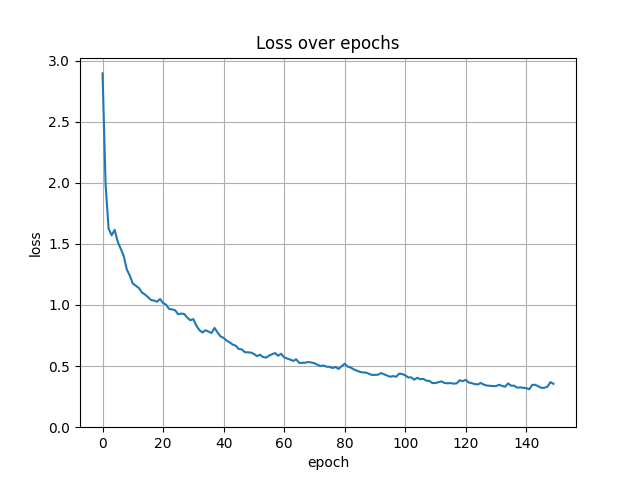

In [8]:

# 4 Orbital - Halcyon
!youtube-dl -ci -f "bestaudio[ext=m4a]" https://www.youtube.com/watch?v=3SwwljI-8JY -o 'youtube_audio.m4a'
!ffmpeg -i 'youtube_audio.m4a' -ac 2 -f wav full.wav

number_of_epochs = 300 # will take cca 8min
number_of_epochs = 150 # will take cca 4min

# ----[keep the same bellow]-------------------------------------------------------------------
!ffmpeg -ss 60 -i full.wav -t 60 -c copy sample.wav
#"""
!mkdir __music_samples
!mkdir __music_samples/sample/
!mv sample.wav __music_samples/sample/
!mkdir __saved_models/

# takes time!
!python training_handler.py -target_file __music_samples/sample/ -amount_epochs $number_of_epochs -batch_size 512
from IPython.display import clear_output 
clear_output()

import glob
import numpy as np
l = glob.glob("__saved_models/*.wav")
a = l[np.random.randint(len(l))]
i = glob.glob("__saved_models/*.png")
from IPython.display import Audio, Image
display(Audio(a))
display(Image(i[0]))
#"""

# Generate

Experiment with different start points (`position_in_the_song`) and lengths (`requested_length`) to build up interesting sequences by jumping to different parts in the song

In [11]:
from server_handler import ServerHandler
import settings

my_settings = settings.Settings(args)
my_settings.print_settings()

generation_handler = ServerHandler(my_settings)

# slightly experimental interpolation through the latents while generating ...

generation_handler.change_impulse(0.2) # set to 20% sharp

#Clip 1
position_in_the_song = 0.1
requested_length = 400

generation_handler.change_impulse_smoothly_start(position_in_the_song) # allow interpolation
audio_arr_exp1, t_predict, t_reconstruct = generation_handler.generate_audio_sample(requested_length, interactive_i=position_in_the_song)

#Clip 2
position_in_the_song = 0.6
requested_length = 400

generation_handler.change_impulse_smoothly_start(position_in_the_song)
audio_arr_exp2, t_predict, t_reconstruct = generation_handler.generate_audio_sample(requested_length, interactive_i=position_in_the_song)

#Clip 3
position_in_the_song = 0.9
requested_length = 400

generation_handler.change_impulse_smoothly_start(position_in_the_song)
audio_arr_exp3, t_predict, t_reconstruct = generation_handler.generate_audio_sample(requested_length, interactive_i=position_in_the_song)

clear_output()

# Play Audio

In [12]:
import librosa
from IPython.display import Audio, Image
print(audio_arr_exp1.shape)
print(audio_arr_exp2.shape)
print(audio_arr_exp3.shape)
audio_arr_exp = np.concatenate([audio_arr_exp1,audio_arr_exp2,audio_arr_exp3])

out_name = 'generated_output_exp_concat.wav'
librosa.output.write_wav(out_name, audio_arr_exp, sr=sample_rate)
Audio(out_name)

(204335,)
(204335,)
(204335,)


# Clean up if you are going to train a new model from a different youtube video

In [ ]:
# fast cleanup
!mkdir unused
!mv __music_samples unused/
!mv __saved_models unused/
!mv audio_data_source unused/
!mv *.wav unused/